In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from lib.simdata_i3 import I3SimHandler
from lib.geo import center_track_pos_and_time_based_on_data

In [9]:
event_index = 15

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

muon energy: 1.5 TeV
n_doms 61


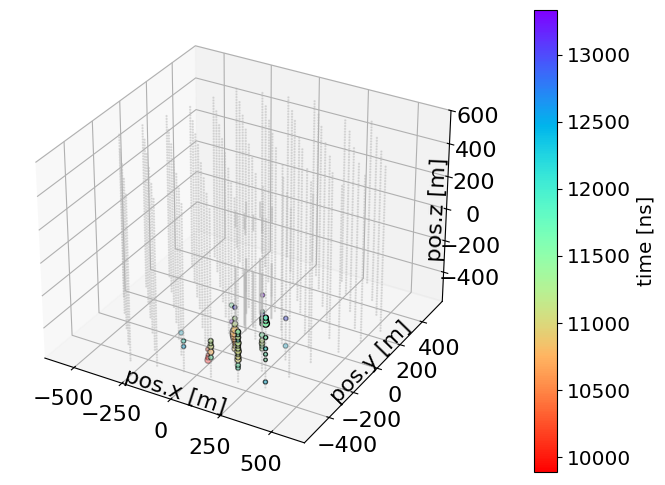

In [10]:
geo = pd.read_csv('/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')
df = event_data

def plot_event(df, geo=None):
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(projection='3d')
    ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
    ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
    ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)

    idx = df['charge'] > 0
    
    try:
        im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.5, c='0.7', alpha=0.4)
    except:
        pass
    
    im = ax.scatter(df[idx]['x'], df[idx]['y'], df[idx]['z'], s=np.sqrt(df[idx]['charge']*100), c=df[idx]['time'], 
                    cmap='rainbow_r',  edgecolors='k', zorder=1000)
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
    cb = plt.colorbar(im, orientation="vertical", pad=0.1)
    cb.set_label(label='time [ns]', size='x-large')
    cb.ax.tick_params(labelsize='x-large')
        
    plt.show()

plot_event(df, geo)

In [11]:
from lib.experimental_methods import get_vert_seeds

In [6]:
# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, 
                                                                                  track_pos, 
                                                                                  track_time, 
                                                                                  track_src)
print("shifted seed vertex:", centered_track_pos)

original seed vertex: [  -65.71173861  1800.82339061 -1057.15159503]
shifted seed vertex: [ 407.88112043  162.47186024 -234.15666758]


In [7]:
get_vert_seeds(centered_track_pos, track_src)

[Array([ 407.88112043,  162.47186024, -234.15666758], dtype=float64),
 array([399.78140389, 190.49209479, -81.6795839 ]),
 array([ 551.73142556,  132.62402141, -284.31836844]),
 array([ 302.14239526,   60.47614579, -284.31836844]),
 array([ 513.6198456 ,  264.46757469, -183.99496673]),
 array([ 415.98083697,  134.45162568, -386.63375126]),
 array([ 264.03081531,  192.31969907, -183.99496673])]

In [8]:
track_src.shape

(2,)